# Análise de Sentimentos dos Comentários da IMDb
por Gleice Garcia
<hr>

### Etapas
<ol type="1">
    <li>Importação dos Dados (50K IMDB Movie Review)</li>
    <li>Limpeza e Pré processamento dos Dados</li>
    <li>Divisão em Treino e Teste</li>
    <li>Tokenize e Pad/Truncate</li>
    <li>Construção do Modelo</li>
    <li>Treino e Teste</li>
</ol>

<hr>

In [16]:
import pandas as pd    
import numpy as np     
from nltk.corpus import stopwords  
from sklearn.model_selection import train_test_split       
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences   
from tensorflow.keras.models import Sequential     
from tensorflow.keras.layers import Embedding, LSTM, Dense 
from tensorflow.keras.callbacks import ModelCheckpoint   
from tensorflow.keras.models import load_model  
import re
import matplotlib.pyplot as plt

In [17]:
df_imdb = pd.read_csv('IMDB Dataset.csv')
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [18]:
df_imdb.shape

(50000, 2)

In [19]:
df_imdb.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


<AxesSubplot:>

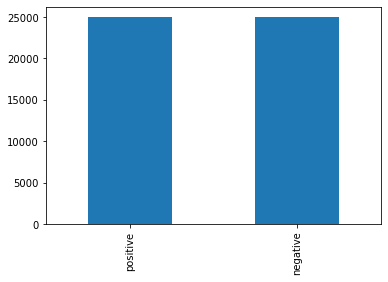

In [25]:
df_imdb['sentiment'].value_counts().plot(kind = 'bar')

<hr>

### Limpeza e Pré processamento dos Dados

Antes da divisão dos dados em treino e teste e da construção do modelo, é fundamental que seja feito um tratamento para remover tags html, pontuações, caracteres não alfanuméricos e palavras 'stopwords'. Além disso, é importante que seja atribuído um valor para os sentimentos positivos e negativos. Neste caso 1 e 0, respectivamente.

In [26]:
# Importa o conjunto de stopwords em inglês 
eng_stops = set(stopwords.words('english'))

In [27]:
df = pd.read_csv('IMDB Dataset.csv')
x_data = df['review']       # Reviews/Input
y_data = df['sentiment']    # Sentiment/Output

# Tratamento do texto
x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove tags html 
x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove caracteres especiais
x_data = x_data.apply(lambda review: [w for w in review.split() if w not in eng_stops])  # remove as stopwords
x_data = x_data.apply(lambda review: [w.lower() for w in review])   # converte para letra maiuscula 

In [28]:
# Codificação do sentimento (positivo e negativo)
y_data = y_data.replace('positive', 1)
y_data = y_data.replace('negative', 0)

<hr>

### Divisão em Treino e Teste
Os dados são divididos 80% em treino e 20% em teste através da função train_test_split(). Essa função embaralha os dados no momento em que separa os dados em dois conjuntos e isso é importante porque no conjunto de dados origina as avaliações e os sentimentos estão em ordem, primeiro avaliações positivas e depois as negativas. Isso garante que os dados serão distribuídos igualmente no modelo, trazendo maior precisão para as previsões.

In [29]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x_data, y_data, test_size = 0.2)

print('Conjunto de Treino')
print(x_treino, '\n')
print('Conjunto de Teste')
print(x_teste, '\n')
print('Conjunto de Treino')
print(y_treino, '\n')
print('Conjunto de Teste')
print(y_teste)

Conjunto de Treino
11442    [show, one, worst, shows, all, time, absolutel...
23025    [as, much, movie, good, nothing, say, said, al...
4576     [i, see, lot, people, liked, movie, to, movie,...
6018     [this, almost, action, less, film, following, ...
32608    [this, movie, right, bad, i, love, war, movies...
                               ...                        
34457    [some, people, thought, funny, loved, politica...
12626    [the, waterdance, the, main, character, the, w...
37444    [every, sunday, eleven, minute, short, subject...
18413    [give, movie, break, its, worth, least, that, ...
23355    [i, big, fan, first, critters, movie, the, sec...
Name: review, Length: 40000, dtype: object 

Conjunto de Teste
34210    [edward, furlong, christina, ricci, excellent,...
10145    [i, would, hesitate, put, adaptation, death, t...
28098    [i, feel, sorry, people, go, movies, pad, penc...
37095    [this, movie, crappy, beyond, limits, it, incr...
6937     [i, rented, domino, whim

<hr>

### Tokenize, Pad/Truncate 
Após a divisão dos dados em conjuntos de treinamento e teste, é necessário transformar os comentários em dados númericos inteiros. 
Além disso, pelos comentários terem comprimentos diferentes foi preciso fazer um preenchimento com zeros, para que ficassem todas com o mesmo tamanho.

In [30]:
# função para encontrar o comprimento máximo das resenhas pela média de comprimento geral.
def maior_tamanho():
    comprimento = []
    for review in x_treino:
        comprimento.append(len(review))

    return int(np.ceil(np.mean(comprimento)))

In [31]:
token = Tokenizer(lower=False)   
token.fit_on_texts(x_treino)
x_treino = token.texts_to_sequences(x_treino)
x_teste = token.texts_to_sequences(x_teste)

In [32]:
max_len = maior_tamanho()

x_treino = pad_sequences(x_treino, maxlen=max_len, padding='post', truncating='post')
x_teste = pad_sequences(x_teste, maxlen=max_len, padding='post', truncating='post')

total_palavras = len(token.word_index) + 1

print('Encoded X Train\n', x_treino, '\n')
print('Encoded X Test\n', x_teste, '\n')
print('Maximum review length: ', max_len)

Encoded X Train
 [[  45    5  155 ...    0    0    0]
 [ 110   17    3 ...    0    0    0]
 [   1   15   82 ...  310 1491  829]
 ...
 [  83 2735 5737 ...    0    0    0]
 [ 105    3  907 ...    0    0    0]
 [   1  101  231 ...    0    0    0]] 

Encoded X Test
 [[ 2364 18222  5255 ...     0     0     0]
 [    1    12  7256 ...   117  2493    68]
 [    1   134   666 ...     0     0     0]
 ...
 [  106   318  2459 ...     0     0     0]
 [  374   212   194 ...     0     0     0]
 [    1   940     5 ... 36316  6615  2054]] 

Maximum review length:  130


<hr>

### Construção do Modelo

**Camada embedding**: Utilizada para vetorizar o texto. O embedding de palavras faz a representação na qual, por meio de um agrupamento, palavras semelhantes têm codificação semelhante. Os valores para o embedding são parâmetros treináveis (pesos aprendidos durante o treinamento, da mesma maneira que um modelo aprende pesos para uma camada densa). 

**Camada LSTM** : tem a capacidade tanto de lembrar quanto de esquecer
o estado anterior quando essa informação não for mais necessária. Seus componentes são: 

**Forget Gate** : decide qual informação manter ou esquecer;

**Input Gate** : adição de informações úteis ao estado da célula (blocos de memória) passando a saída anterior e a entrada atual na função de ativação sigmóide. Os valores do vetor e os valores regulados são multiplicados para obter as informações úteis.

**Output Gate** : extrair informações úteis do estado da célula atual para ser apresentadas como uma saída

**Camada Densa** : calcula a entrada com a matriz de peso e bias (opcional), e usando uma função de ativação.

Foi utilizado o otimizador Adam e a função de custo Binary Crossentropy já que a saída é binária.


In [33]:
emb_dim = 32 # o comprimento do vetor é um parâmetro. Números menores são ideais para conjuntos menores.
lstm_out = 64

model = Sequential()
model.add(Embedding(total_palavras, emb_dim, input_length = max_len))
model.add(LSTM(lstm_out))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           2958560   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,983,457
Trainable params: 2,983,457
Non-trainable params: 0
_________________________________________________________________
None


<hr>

### Treino

O treino consiste em ajustar os dados de entrada (x_treino) e de saída/rótulo (y_treino). Para isso foi utilizado o método de aprendizado de mini-batch com batch_size de 128 e 5 épocas.

Foi adicionado um checkpoint para salvar o modelo localmente para cada época se sua precisão melhorar em relação a anterior.

In [34]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [35]:
model.fit(x_treino, y_treino, batch_size = 128, epochs = 5, callbacks=[checkpoint])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.7305
Epoch 00001: accuracy improved from -inf to 0.73053, saving model to models\LSTM.h5
313/313 [==============================] - 29s 90ms/step - loss: 0.4770 - accuracy: 0.7305
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9221
Epoch 00002: accuracy improved from 0.73053 to 0.92210, saving model to models\LSTM.h5
313/313 [==============================] - 28s 90ms/step - loss: 0.2163 - accuracy: 0.9221
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.9625
Epoch 00003: accuracy improved from 0.92210 to 0.96255, saving model to models\LSTM.h5
313/313 [==============================] - 29s 92ms/step - loss: 0.1184 - accuracy: 0.9625
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9796
Epoch 00004: accuracy improved from 0.96255 to 0.97960, saving model to models\LSTM.h5
31

<hr>


### Teste

O teste consiste em avaliar se o modelo consegue prever o sentimento dos comentários novos (x_teste) comparando com os rótulos destes comentários (y_teste). Em seguida é calculada a precisão do modelo que resultou em 86,63%.


In [36]:
y_pred = (model.predict(x_teste) > 0.5).astype("int32")

true = 0
for i, y in enumerate(y_teste):
    if y == y_pred[i]:
        true += 1

print('Predições corretas: {}'.format(true))
print('Predições incorretas: {}'.format(len(y_pred) - true))
print('Acurácia: {}'.format(true/len(y_pred)*100))

Predições corretas: 8725
Predições incorretas: 1275
Acurácia: 87.25


<hr>

### Resultados 

In [37]:
loaded_model = load_model('models/LSTM.h5') # modelo salvo

In [43]:
# o modelo recebe um commentário para ser classificado
comentario_1 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_2 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_3 = str(input('Comentário sobre o filme: '))
print('\n')
comentario_4 = str(input('Comentário sobre o filme: '))

Comentário sobre o filme: This has got to be the worse ever spiderman 😫 got bored after an hour lost interest my husband enjoyed though Shame they didn't have a 0 button 😕 because I would have scored 0 instead of 1.


Comentário sobre o filme: Watched this because people recommended it, plus the cast. But I found myself FORCING me to watch it only for those reasons. Movie is not funny nor really that smart.


Comentário sobre o filme: This film really is something special.I enjoyed every single second and would happily have lapped up hours more of it. Everything about it is executed so well. I mean SO well.Not a single Marvel fan alive will be disappointed by this 10/10.


Comentário sobre o filme: Don't Look Up is a phenomenal satire that's really funny, twisted and stressful to watch, using its giant meteor hurtling towards the planet to criticize and make fun of a wide variety of topics whilst also working as a sombre warning and metaphor for many of the current world issues.


In [66]:
# a entrada é pré processada antes de passar pelo modelo
regex = re.compile(r'[^a-zA-Z\s]')
comentario_1 = regex.sub('', comentario_1)
comentario_2 = regex.sub('', comentario_2)
comentario_3 = regex.sub('', comentario_3)
comentario_4 = regex.sub('', comentario_4)
print('Comentário 1 tratado (negativo): ', comentario_1)
print('\n')
print('Comentário 2 tratado (negativo): ', comentario_2)
print('\n')
print('Comentário 3 tratado (positivo): ', comentario_3)
print('\n')
print('Comentário 4 tratado (positivo): ', comentario_4)

Comentário 1 tratado (negativo):  This has got to be the worse ever spiderman  got bored after an hour lost interest my husband enjoyed though Shame they didnt have a  button  because I would have scored  instead of 


Comentário 2 tratado (negativo):  Watched this because people recommended it plus the cast But I found myself FORCING me to watch it only for those reasons Movie is not funny nor really that smart


Comentário 3 tratado (positivo):  This film really is something specialI enjoyed every single second and would happily have lapped up hours more of it Everything about it is executed so well I mean SO wellNot a single Marvel fan alive will be disappointed by this 


Comentário 4 tratado (positivo):  Dont Look Up is a phenomenal satire thats really funny twisted and stressful to watch using its giant meteor hurtling towards the planet to criticize and make fun of a wide variety of topics whilst also working as a sombre warning and metaphor for many of the current world issues


In [51]:
palavras = comentario_1.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_1 = [filtro.lower()]

print('Comentário 1 (negativo) tratado : ', filtro_1)

Comentário 1 tratado com filtro:  ['this got worse ever spiderman  got bored hour lost interest husband enjoyed though shame didnt  button  i would scored  instead ']


In [52]:
palavras = comentario_2.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_2 = [filtro.lower()]

print('Comentário 2 (negativo) tratado : ', filtro_2)

Comentário 2 tratado com filtro:  ['watched people recommended plus cast but i found forcing watch reasons movie funny really smart']


In [53]:
palavras = comentario_3.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_3 = [filtro.lower()]

print('Comentário 3 (positivo) tratado : ', filtro_3)

Comentário 3 tratado com filtro:  ['this film really something speciali enjoyed every single second would happily lapped hours everything executed well i mean so wellnot single marvel fan alive disappointed ']


In [54]:
palavras = comentario_4.split(' ')
filtro = [p for p in palavras if p not in eng_stops]
filtro = ' '.join(filtro)
filtro_4 = [filtro.lower()]

print('Comentário 4 (positivo) tratado : ', filtro_4)

Comentário 4 tratado com filtro:  ['dont look up phenomenal satire thats really funny twisted stressful watch using giant meteor hurtling towards planet criticize make fun wide variety topics whilst also working sombre warning metaphor many current world issues']


In [90]:
print('Comentário 1 (negativo) tratado : ', filtro_1)
print('\n')
print('Comentário 2 (negativo) tratado : ', filtro_2)
print('\n')
print('Comentário 3 (positivo) tratado : ', filtro_3)
print('\n')
print('Comentário 4 (positivo) tratado : ', filtro_4)

Comentário 1 (negativo) tratado :  ['this got worse ever spiderman  got bored hour lost interest husband enjoyed though shame didnt  button  i would scored  instead ']


Comentário 2 (negativo) tratado :  ['watched people recommended plus cast but i found forcing watch reasons movie funny really smart']


Comentário 3 (positivo) tratado :  ['this film really something speciali enjoyed every single second would happily lapped hours everything executed well i mean so wellnot single marvel fan alive disappointed ']


Comentário 4 (positivo) tratado :  ['dont look up phenomenal satire thats really funny twisted stressful watch using giant meteor hurtling towards planet criticize make fun wide variety topics whilst also working sombre warning metaphor many current world issues']


In [60]:
# as palavras são codificadas 
palavras_codificadas_1 = token.texts_to_sequences(filtro_1)
palavras_codificadas_1 = pad_sequences(palavras_codificadas_1, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_1)

[[    8   102   340    51 10785   102  1002   437   334   517   511   423
     70   776  8784  3535     1    12  6625   206     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [61]:
# as palavras são codificadas 
palavras_codificadas_2 = token.texts_to_sequences(filtro_2)
palavras_codificadas_2 = pad_sequences(palavras_codificadas_2, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_2)

[[ 198   21 1069  806   87   30    1  162 4916   33  881    3   71   13
  1205    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [62]:
# as palavras são codificadas 
palavras_codificadas_3 = token.texts_to_sequences(filtro_3)
palavras_codificadas_3 = pad_sequences(palavras_codificadas_3, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_3)

[[    8     4    13    61   423    83   588   240    12  3371 31910   523
    172  2138    16     1   285   146   588  5708   231  1027   564     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [63]:
# as palavras são codificadas 
palavras_codificadas_4 = token.texts_to_sequences(filtro_4)
palavras_codificadas_4 = pad_sequences(palavras_codificadas_4, maxlen=max_len, padding='post', truncating='post')
print(palavras_codificadas_4)

[[ 5295    77  2525  5856  2027  1476    13    71  2271 16365    33   708
   1222  6932 20675   866  1206  6562    25   151  1678  2324  6013  1731
     22   679 15719  1657  4849    37  1845    85  1200     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]]


In [71]:
# pontuação de confiança do previsão da classe do comentário
resultado_1 = loaded_model.predict(palavras_codificadas_1)
print(resultado_1)

[[0.00647682]]


In [72]:
resultado_2 = loaded_model.predict(palavras_codificadas_2)
print(resultado_2)

[[0.92644936]]


In [73]:
resultado_3 = loaded_model.predict(palavras_codificadas_3)
print(resultado_3)

[[0.9967264]]


In [74]:
resultado_4 = loaded_model.predict(palavras_codificadas_4)
print(resultado_4)

[[0.99699455]]


In [81]:
resultados = [0.00647682,0.92644936,0.9967264,0.99699455]
resultados

[0.00647682, 0.92644936, 0.9967264, 0.99699455]

In [84]:
# se a pontuação estiver mais próxima de 0, o comentário tem sentimento negativo. Em contrapartida, se a pontuação estiver próxima a 1, o comentário é positivo.
# foi utilizado um threshold de 0,7 para determinar se a pontuação representa um comentário positivo  ou negativo. Portanto, pontuação maior de 0,7 é positiva e menor que 0,7 é negativa.

if resultado_1 >= 0.7:
    print('positivo')
else:
    print('negativo')

negativo


In [85]:
if resultado_2 >= 0.7:
    print('positivo')
else:
    print('negativo')

positivo


In [86]:
if resultado_3 >= 0.7:
    print('positivo')
else:
    print('negativo')

positivo


In [87]:
if resultado_4 >= 0.7:
    print('positivo')
else:
    print('negativo')

positivo
